In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [2]:
LEVELS = common.LEVELS

In [3]:
grid = vcm.catalog.catalog["grid/c48"].to_dask()

Make it faster

In [4]:
base = "zc-emu-monthly-normfix-m{init}-seed3-30d-v1-{run_type}"
fields = [
    "air_temperature",
    "specific_humidity",
    "cloud_water_mixing_ratio"
]
run_types = ["online", "offline"]
inits = [f"{i:02d}" for i in range(1, 13)]

In [5]:
groups = [base.format(init=init, run_type=run_type) for init, run_type in product(inits, run_types)]
args = list(product(inits, run_types, fields))  

In [6]:
@common.memoize_xarray_out
def get_zonal_avg_v3(group, field):
    data = common.open_group(group)
    return vcm.zonal_average_approximate(data.lat, data[field]).load().to_dataset(name=field)

In [7]:
def get_zonal_avg_p_interp(group, field):
    delp_key = "pressure_thickness_of_atmospheric_layer"
    data = get_zonal_avg_v3(group, field)
    delp = get_zonal_avg_v3(group, delp_key)
    data[delp_key] = delp[delp_key]
    interpolated = common.interp_vertical(data, levels=LEVELS)
    interpolated["pressure"] = interpolated["pressure"] / 100 # to hPa
        
    return interpolated[field]

In [8]:
args = list(product(inits, run_types, fields))
jobs = []

for init, run_type, field in args:
    group = base.format(init=init, run_type=run_type)
    jobs.append(delayed(get_zonal_avg_p_interp)(group, field))

In [9]:
results = Parallel(n_jobs=8)(jobs)

In [10]:
def gather(field_key, args, results, drop_time=True):
    out = defaultdict(list)

    for i, da in enumerate(results):
        month, run_type, field = args[i]
        if field == field_key:
            if drop_time:
                da = da.drop_vars(["time"])
            out[run_type].append(da)
    
    out["offline"] = xr.concat(out["offline"], dim="init")
    out["online"] = xr.concat(out["online"], dim="init")
    
    return out

In [11]:
def get_bias(key, args, results, pct=False, isel_kwargs=None):
    fields = gather(key, args, results)

    if isel_kwargs is None:
        isel_kwargs = {}
    
    online_ds = fields["online"].isel(**isel_kwargs)
    offline_ds = fields["offline"].isel(**isel_kwargs)
    bias = (online_ds - offline_ds).mean(dim="init")
    baseline = offline_ds.mean(dim="init")

    if pct:
        bias /= baseline
    
    return baseline, bias

In [15]:
def get_signif(field, args, results, n_iters=10000):
    fields = gather(field, args, results)

    online = fields["online"]
    offline = fields["offline"]

    reshape_to = tuple([-1] + list(online.values.shape[-2:]))

    _, signif = common.bootstrap_bias_signif(
        offline.values.reshape(reshape_to),
        online.values.reshape(reshape_to),
        n_iters=n_iters
    )

    return signif


def plot_not_signif_scatter(da, signif_mask):
    lat, pressure = xr.broadcast(da.lat, da.pressure)
    not_signif = np.logical_not(signif_mask)
    plt.scatter(lat.values[not_signif], pressure.values[not_signif], marker="x", color="k", alpha=0.3, s=1)



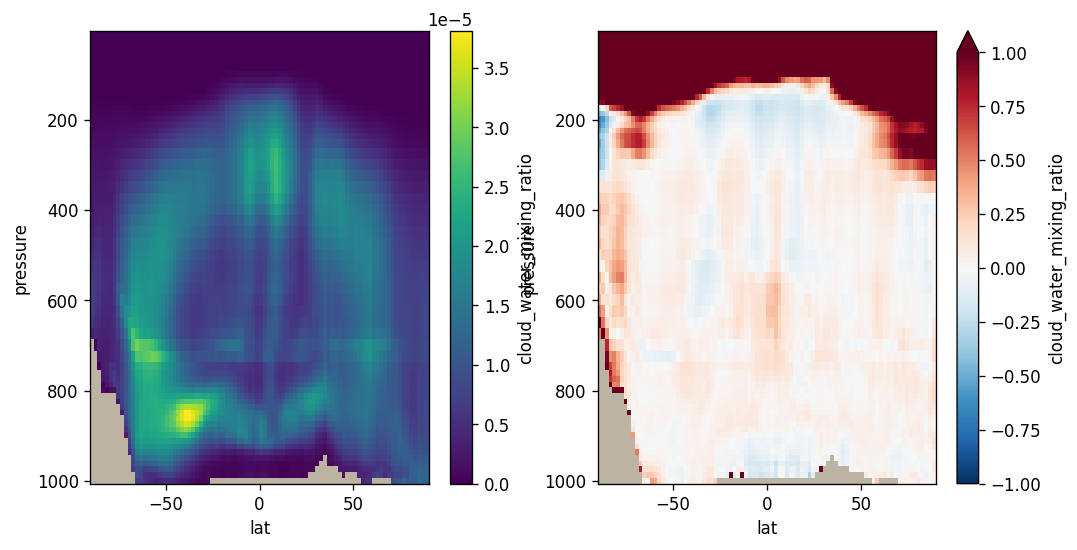

In [19]:
cl_base, cl_bias = get_bias("cloud_water_mixing_ratio", args, results, pct=True)
fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
cl_base.mean(dim="time").plot(y="pressure", yincrease=False, ax=ax[0])
cl_bias.mean(dim="time").plot(y="pressure", yincrease=False, ax=ax[1], vmin=-1, vmax=1, cmap="RdBu_r")
plt.show()

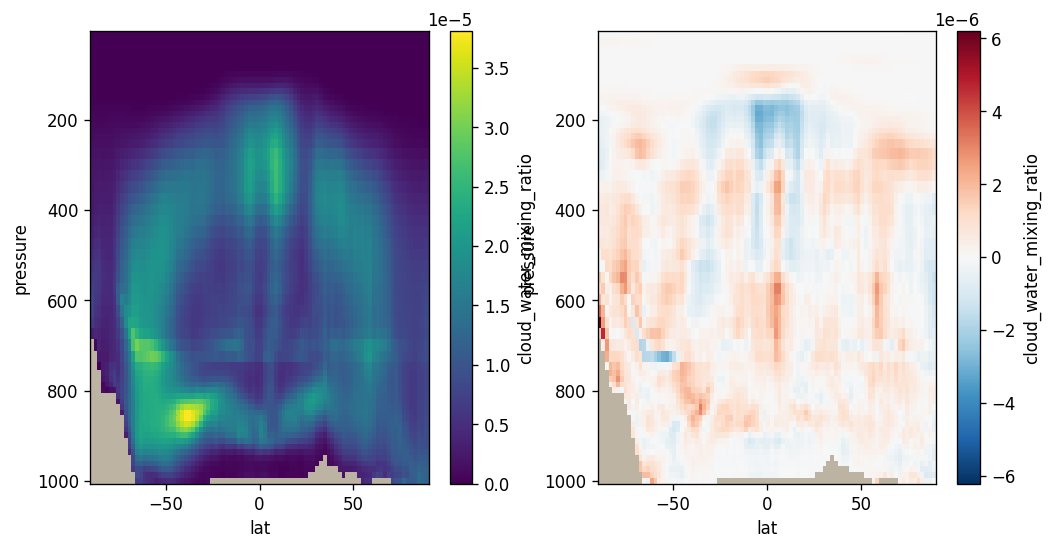

In [13]:
cl_base, cl_online, cloud_water_bias = get_bias("cloud_water_mixing_ratio", args, results, pct=False)
fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
cl_base.mean(dim="time").plot(y="pressure", yincrease=False, ax=ax[0])
cloud_water_bias.mean(dim="time").plot(y="pressure", yincrease=False, ax=ax[1])
plt.show()

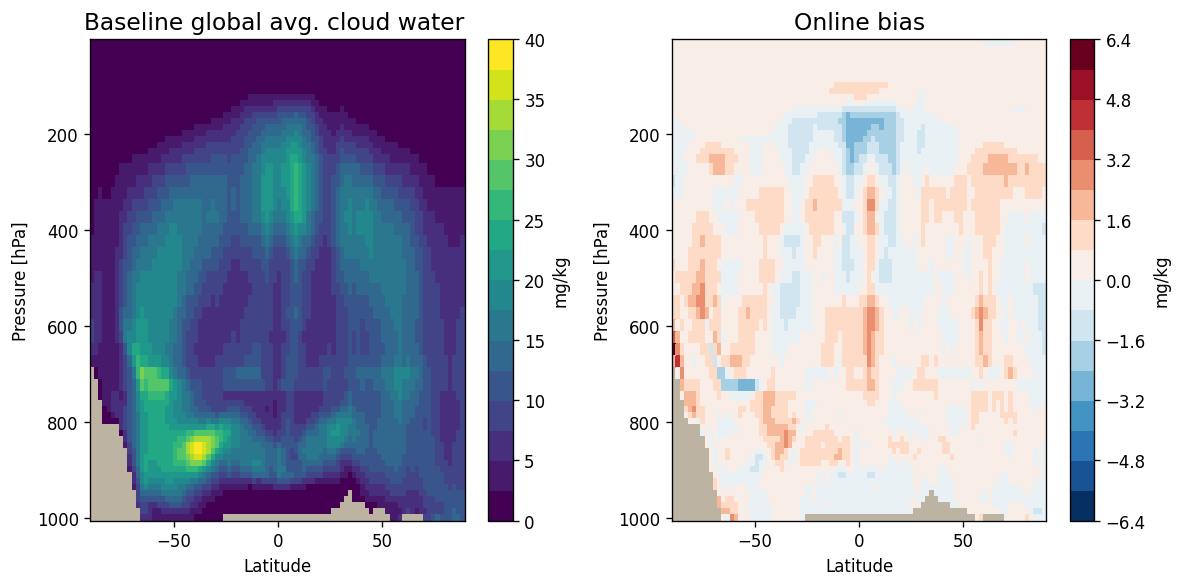

In [20]:
cl_base, cloud_water_bias = get_bias("cloud_water_mixing_ratio", args, results, pct=False)
fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
(cl_base * 1e6).mean(dim="time").plot(
    y="pressure", yincrease=False, cmap=common.Viridis_LAND, 
    ax=ax[0], levels=20, cbar_kwargs=dict(label="mg/kg")
)
(cloud_water_bias * 1e6).mean(dim="time").plot(
    y="pressure", yincrease=False, cmap=common.RdBu_LAND,
    ax=ax[1], levels=20, cbar_kwargs=dict(label="mg/kg")
)
ax[0].set_ylabel("Pressure [hPa]")
ax[1].set_ylabel("Pressure [hPa]")
ax[0].set_xlabel("Latitude")
ax[1].set_xlabel("Latitude")
ax[0].set_title("Baseline global avg. cloud water ", size=14)
ax[1].set_title("Online bias", size=14)
plt.tight_layout()
plt.show()

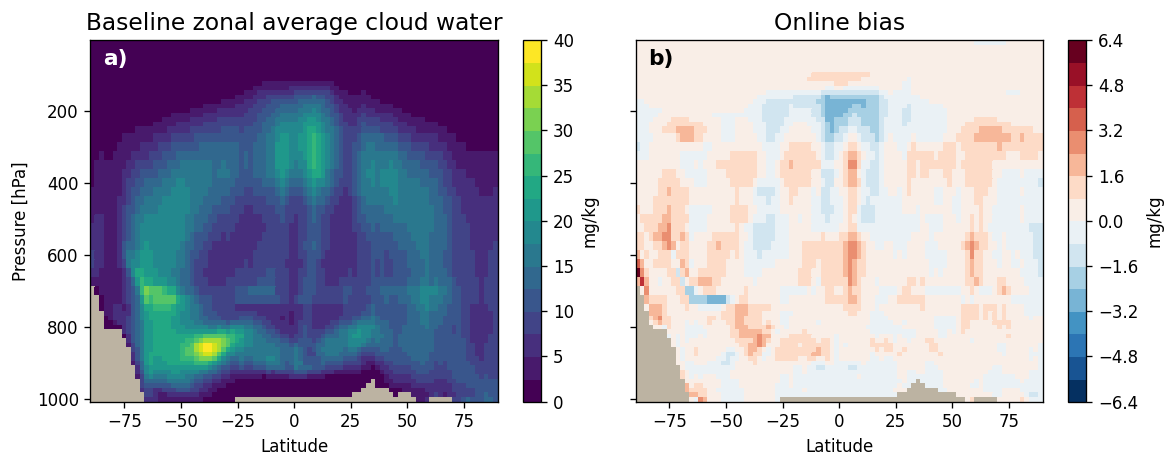

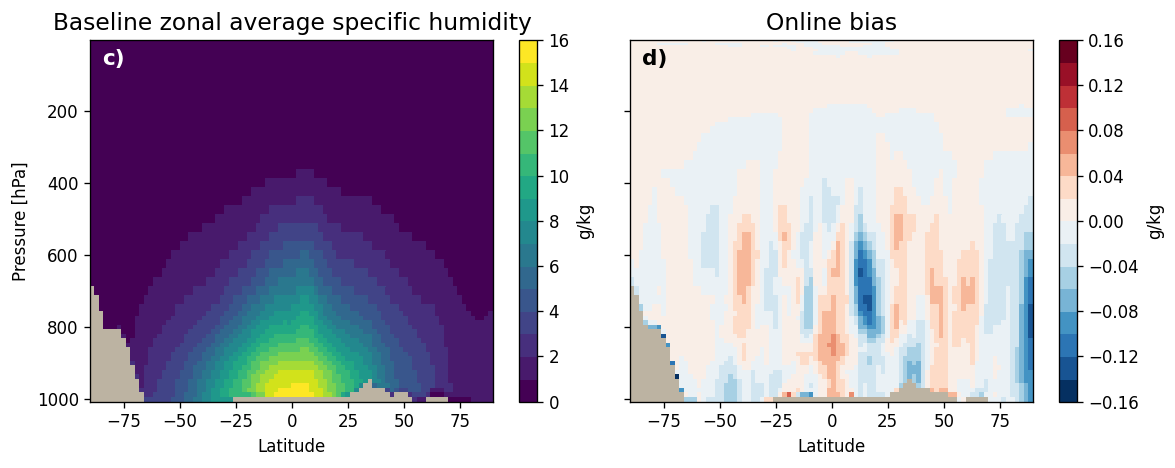

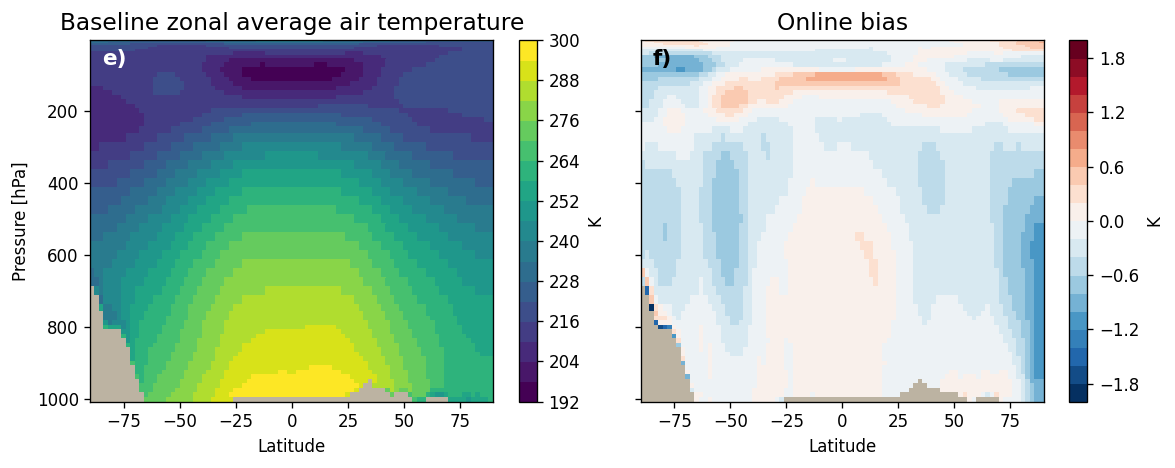

In [14]:
units = {
    "cloud_water_mixing_ratio": "mg/kg",
    "air_temperature": "K",
    "specific_humidity": "g/kg",
}

scale_factors = {
    "cloud_water_mixing_ratio": 1e6,
    "specific_humidity": 1e3,
}

simple_name = {
    "cloud_water_mixing_ratio": "cloud water",
    "air_temperature": "air temperature",
    "specific_humidity": "specific humidity",
}

figsize = (10, 4)

fig_labels = [("a)", "b)"), ("c)", "d)"), ("e)", "f)")]

for f, labels  in zip(fields[::-1], fig_labels):
    baseline, bias = get_bias(f, args, results, pct=False)
    scale_factor = scale_factors.get(f, 1)
    unit_label = units[f]
    
    fig, ax = plt.subplots(1, 2, dpi=120, figsize=figsize, sharey=True)
    left, right = labels
    (baseline * scale_factor).mean(dim="time").plot(y="pressure", yincrease=False, cmap=common.Viridis_LAND, ax=ax[0], levels=20, cbar_kwargs=dict(label=unit_label), rasterized=True)
    (bias * scale_factor).mean(dim="time").plot(y="pressure", yincrease=False, cmap=common.RdBu_LAND, ax=ax[1], levels=20, cbar_kwargs=dict(label=unit_label), rasterized=True)
    ax[0].text(0.03, 0.93, left, fontdict=dict(color="white", size=13, weight="bold"), transform=ax[0].transAxes)
    ax[1].text(0.03, 0.93, right, fontdict=dict(color="black", size=13, weight="bold"), transform=ax[1].transAxes)
    ax[0].set_ylabel("Pressure [hPa]")
    ax[1].set_ylabel("")
    ax[0].set_xlabel("Latitude")
    ax[1].set_xlabel("Latitude")
    ax[0].set_title(f"Baseline zonal average {simple_name[f]}", size=14)
    ax[1].set_title("Online bias", size=14)
    plt.tight_layout()
    common.savefig(f"zonal_bias_{f}")
    plt.show()

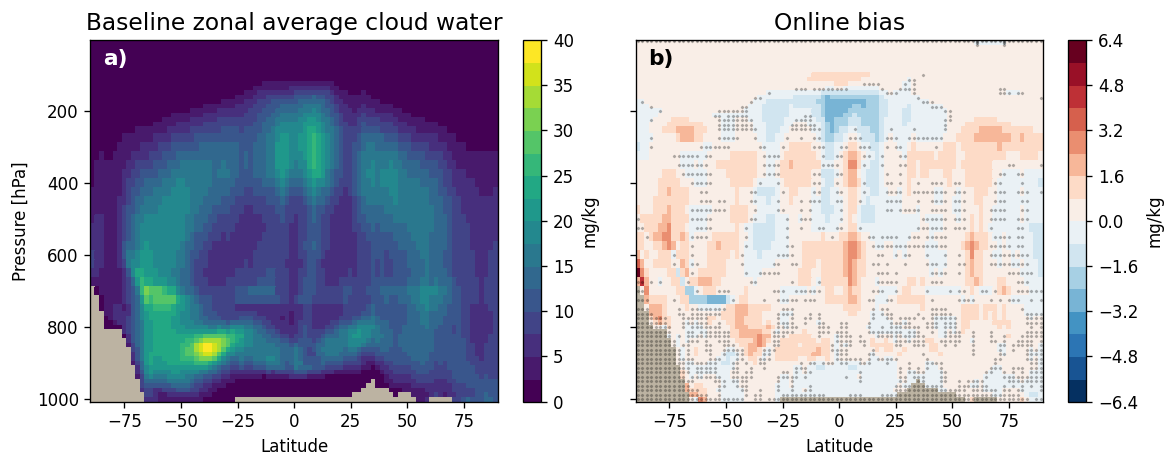

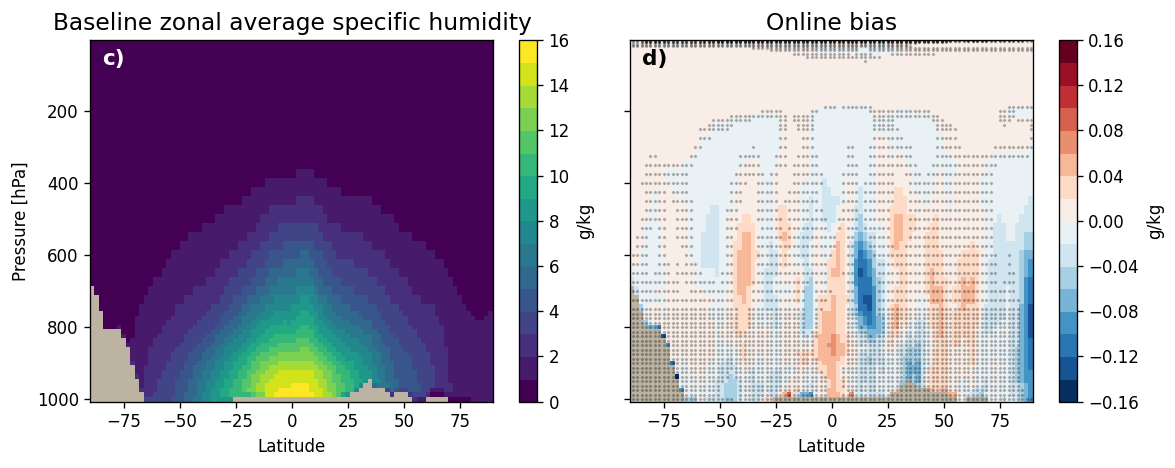

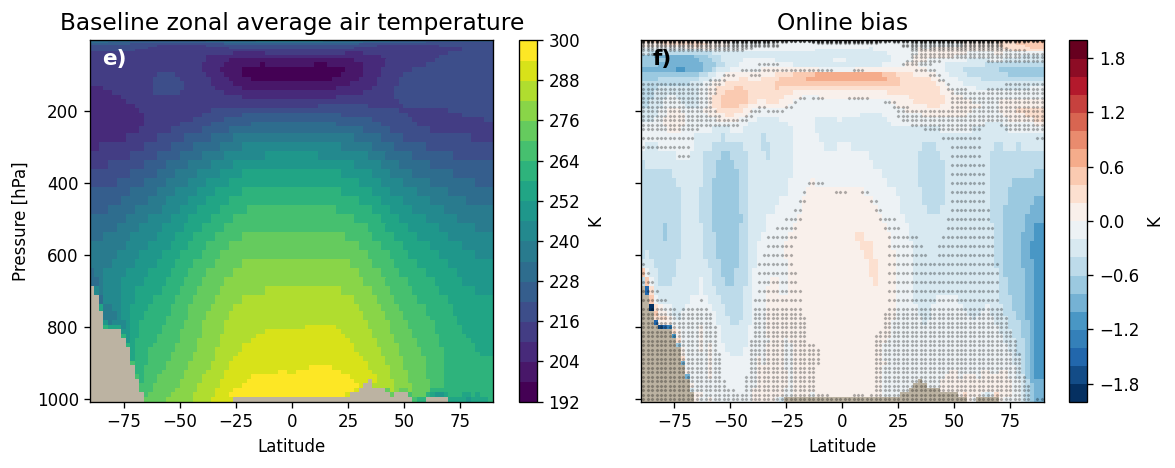

In [18]:
for f, labels  in zip(fields[::-1], fig_labels):
    baseline, bias = get_bias(f, args, results, pct=False)
    scale_factor = scale_factors.get(f, 1)
    unit_label = units[f]
    
    fig, ax = plt.subplots(1, 2, dpi=120, figsize=figsize, sharey=True)
    left, right = labels
    (baseline * scale_factor).mean(dim="time").plot(y="pressure", yincrease=False, cmap=common.Viridis_LAND, ax=ax[0], levels=20, cbar_kwargs=dict(label=unit_label), rasterized=True)
    (bias * scale_factor).mean(dim="time").plot(y="pressure", yincrease=False, cmap=common.RdBu_LAND, ax=ax[1], levels=20, cbar_kwargs=dict(label=unit_label), rasterized=True)
    signif = get_signif(f, args, results, n_iters=10_000)
    plot_not_signif_scatter(bias, signif)
    ax[0].text(0.03, 0.93, left, fontdict=dict(color="white", size=13, weight="bold"), transform=ax[0].transAxes)
    ax[1].text(0.03, 0.93, right, fontdict=dict(color="black", size=13, weight="bold"), transform=ax[1].transAxes)
    ax[0].set_ylabel("Pressure [hPa]")
    ax[1].set_ylabel("")
    ax[0].set_xlabel("Latitude")
    ax[1].set_xlabel("Latitude")
    ax[0].set_title(f"Baseline zonal average {simple_name[f]}", size=14)
    ax[1].set_title("Online bias", size=14)
    plt.tight_layout()
    # common.savefig(f"zonal_bias_{f}")
    plt.show()

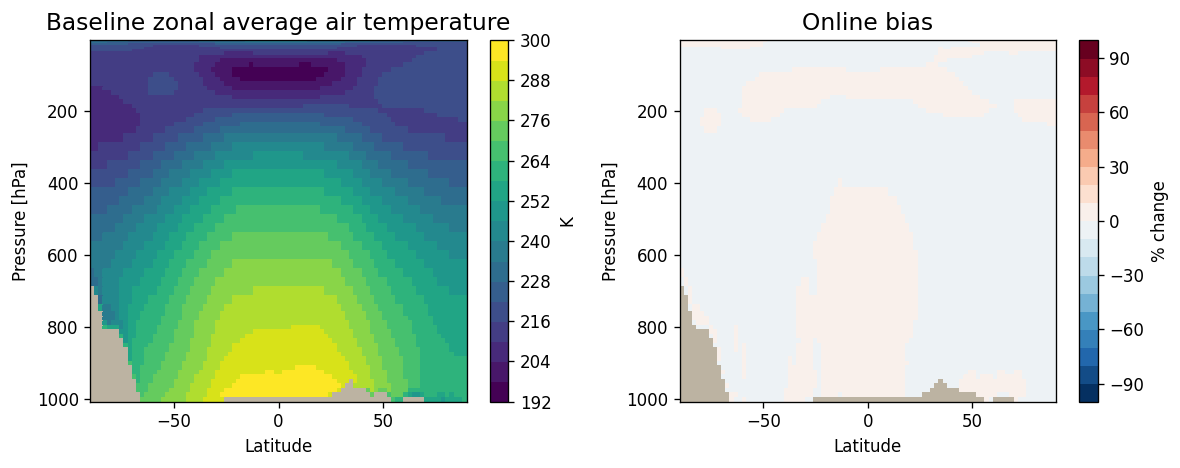

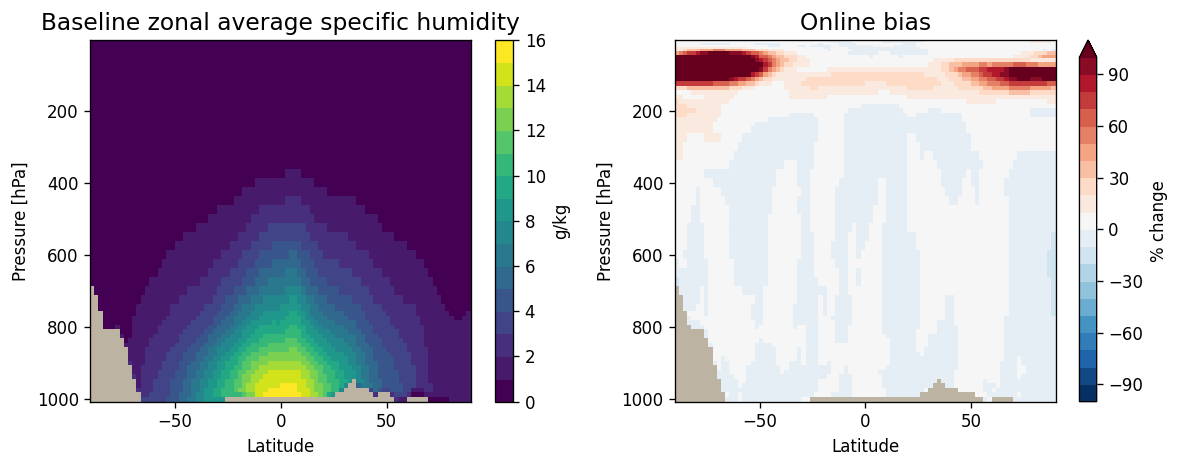

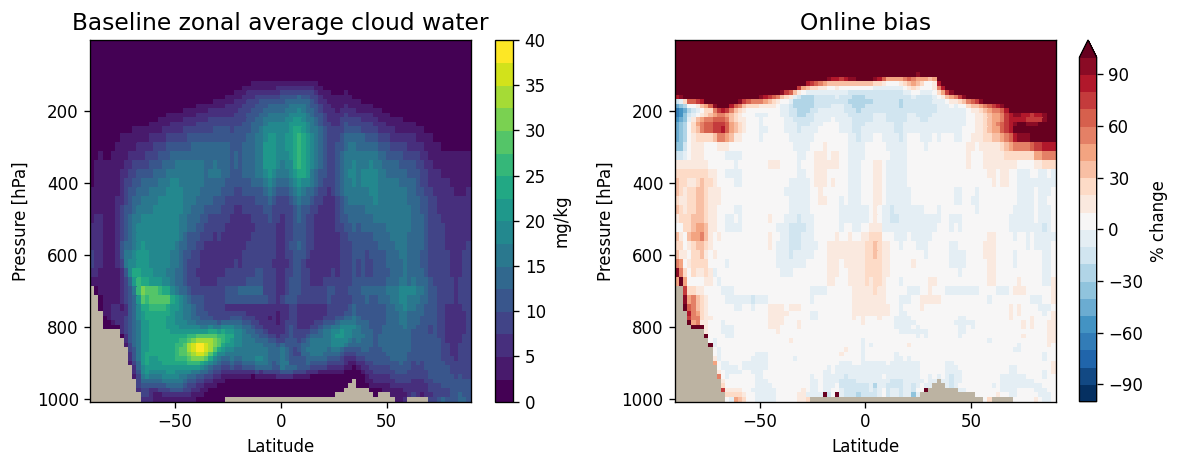

In [25]:
for f in fields:
    baseline, bias = get_bias(f, args, results, pct=True)
    scale_factor = scale_factors.get(f, 1)
    unit_label = units[f]
    
    fig, ax = plt.subplots(1, 2, dpi=120, figsize=figsize)
    (baseline * scale_factor).mean(dim="time").plot(y="pressure", yincrease=False, cmap=common.Viridis_LAND, ax=ax[0], levels=20, cbar_kwargs=dict(label=unit_label), rasterized=True)
    (bias * 100).mean(dim="time").plot(y="pressure", yincrease=False, ax=ax[1], cmap=common.RdBu_LAND, levels=21, vmin=-100, vmax=100, cbar_kwargs=dict(label="% change"), rasterized=True)
    ax[0].set_ylabel("Pressure [hPa]")
    ax[1].set_ylabel("Pressure [hPa]")
    ax[0].set_xlabel("Latitude")
    ax[1].set_xlabel("Latitude")
    ax[0].set_title(f"Baseline zonal average {simple_name[f]}", size=14)
    ax[1].set_title("Online bias", size=14)
    plt.tight_layout()
    plt.show()

In [17]:
@common.memoize_xarray_out
def get_zonal_avg_RH_seed5(group):
    data = common.open_group(group)
    delp_key = "pressure_thickness_of_atmospheric_layer"
    pressure = data[delp_key].cumsum(dim="z") + 300.0
    humidity = data["specific_humidity"]
    temperature = data["air_temperature"]
    rh = vcm.relative_humidity_from_pressure(temperature, humidity, pressure)
    rh_zonal = vcm.zonal_average_approximate(data.lat, rh)
    delp_zonal = get_zonal_avg_v3(group, delp_key)[delp_key]
    zonal_ds = rh_zonal.to_dataset(name="relative_humidity")
    zonal_ds[delp_key] = delp_zonal
    interpolated = common.interp_vertical(zonal_ds, levels=LEVELS)
    interpolated["pressure"] = interpolated["pressure"] / 100 # to hPa
        
    return interpolated["relative_humidity"].load()

In [18]:

delp_key = "pressure_thickness_of_atmospheric_layer"
delp_zonal = get_zonal_avg_v3(groups[0], delp_key)[delp_key]

In [19]:
rh_results = Parallel(n_jobs=12)([delayed(get_zonal_avg_RH_seed5)(g) for g in groups])

In [20]:
rh_ds = defaultdict(list)

for group, ds in zip(groups, rh_results):
    try:
        da = ds["relative_humidity"]
    except KeyError:
        da = ds

    da = da.drop_vars(["time"])
    if "offline" in group:
        rh_ds["offline"].append(da)
    else:
        rh_ds["online"].append(da)

rh_ds["offline"] = xr.concat(rh_ds["offline"], dim="init")
rh_ds["online"] = xr.concat(rh_ds["online"], dim="init")

In [21]:
rh = rh_ds["offline"]
rh_bias = rh_ds["online"] - rh


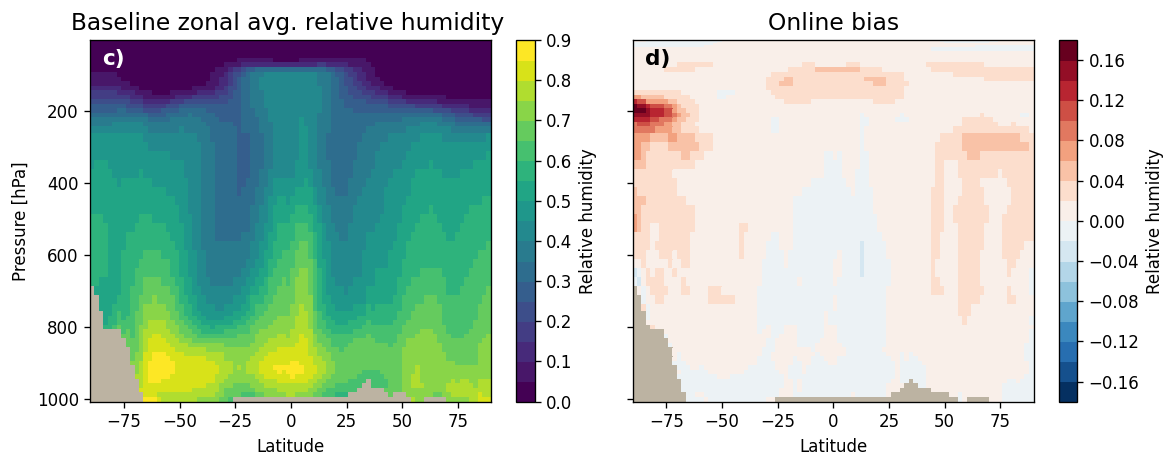

In [27]:

fig, ax = plt.subplots(1, 2, dpi=120, figsize=figsize, sharey=True)
(rh).mean(dim=["time", "init"]).plot(
    y="pressure", yincrease=False, cmap=common.Viridis_LAND, 
    ax=ax[0], levels=20, cbar_kwargs=dict(label="Relative humidity"),
    rasterized=True
)
(rh_bias).mean(dim=["time", "init"]).plot(
    y="pressure", yincrease=False, cmap=common.RdBu_LAND,
    ax=ax[1], levels=20, cbar_kwargs=dict(label="Relative humidity"),
    rasterized=True
)
ax[0].set_ylabel("Pressure [hPa]")
ax[1].set_ylabel("")
ax[0].set_xlabel("Latitude")
ax[1].set_xlabel("Latitude")

ax[0].text(0.03, 0.93, "c)", fontdict=dict(color="white", size=13, weight="bold"), transform=ax[0].transAxes)
ax[1].text(0.03, 0.93, "d)", fontdict=dict(color="black", size=13, weight="bold"), transform=ax[1].transAxes)
ax[0].set_title("Baseline zonal avg. relative humidity ", size=14)
ax[1].set_title("Online bias", size=14)
plt.tight_layout()
common.savefig("zonal_bias_relative_humidity")
plt.show()

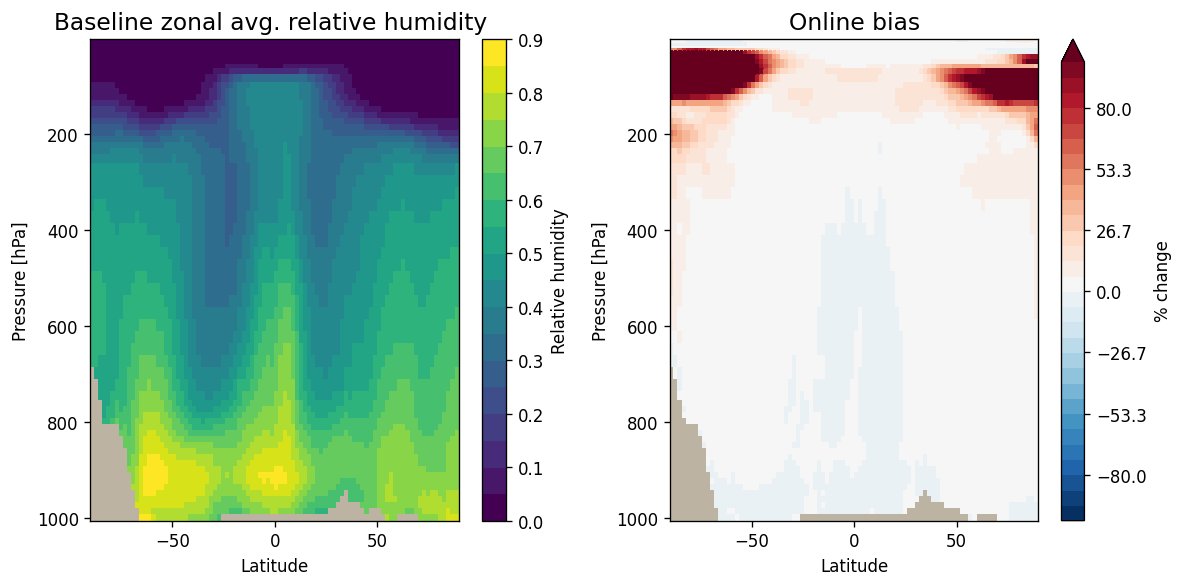

In [31]:

fig, ax = plt.subplots(1, 2, dpi=120, figsize=(10, 5))
(rh).mean(dim=["time", "init"]).plot(
    y="pressure", yincrease=False, cmap=common.Viridis_LAND, 
    ax=ax[0], levels=20, cbar_kwargs=dict(label="Relative humidity")
)
(rh_bias / rh * 100).mean(dim=["time", "init"]).plot(
    y="pressure", yincrease=False, cmap=common.RdBu_LAND,
    ax=ax[1], levels=31, cbar_kwargs=dict(label="% change"),
    vmax=100, vmin=-100
)
ax[0].set_ylabel("Pressure [hPa]")
ax[1].set_ylabel("Pressure [hPa]")
ax[0].set_xlabel("Latitude")
ax[1].set_xlabel("Latitude")
ax[0].set_title("Baseline zonal avg. relative humidity ", size=14)
ax[1].set_title("Online bias", size=14)
plt.tight_layout()
plt.show()